# MTE 544 Report

|Stephen Wang|Ajit Rakhra|Howard Dong|
|:-:|:-:|:-:|
|x2274wan|a3rakhra|h53dong|
|20821034|20832703|20847639|

Station 2, Robot 7 on Fri Sept 29 at 8:30 AM

In [1]:
%config InlineBackend.figure_formats = ["svg"]

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import re

We have produced the following trajectory paths by logging the `/odom` topic containing `nav_msgs/msg/Odometry`, which contained the estimated robot position; acceleration was measured on `/imu` that contained `sensor_msgs/msg/Imu`; laser scan was obtained on `/scan` that contained `sensor_msgs/msg/LaserScan`.

In [99]:
def get_data(name, parse=True):
    with open(name) as f:
        f.readline()
        data = f.read()
    if parse:
        return np.fromstring(data, sep=", ")
    else:
        return data

In [182]:
def make_graph(motion):
    name = motion.lower()
    odom = get_data(f"odom_content_{name}.csv").reshape(-1, 4)
    imu = get_data(f"imu_content_{name}.csv").reshape(-1, 4)
    laser = get_data(f"laser_content_{name}.csv", parse=False).split("\n")[5]
    
    fig, axes = plt.subplots(1,4, figsize=(16,2))
    a = axes[0]
    a.set_title(f"{motion} Trajectory")
    a.set_xlabel("x")
    a.set_ylabel("y")
    a.grid()
    a.plot(odom[:,0], odom[:,1])
    a.axis("scaled")

    a = axes[1]
    a.set_title(f"{motion} States Over Time")
    a.set_xlabel("t")
    a.set_ylabel("value")
    a.grid()
    for i in range(3):
        a.plot(odom[:,3] - odom[0,3], odom[:,i])
    a.legend(["x", "y", r"$\theta$"])
    
    a = axes[2]
    a.set_title(f"{motion} IMU")
    a.set_xlabel("t")
    a.set_ylabel(r"value")
    a.grid()
    for i in range(3):
        a.plot(imu[:,3] - imu[0,3], imu[:,i])
    a.legend([r"$a_x$", r"$a_y$", r"$\omega_z$"])
    
    a = axes[3]
    a.set_title(f"{motion} Laser Scan")
    a.set_xlabel("x")
    a.set_ylabel("y")
    a.grid()
    angles = np.arange(720) / 720 * 2*np.pi
    ranges = re.match(r"^array\(\'f\'\, \[(.*)\]", laser).group(1)
    ranges = np.fromstring(ranges, sep=", ")
    indices = ranges < np.inf

    x = ranges[indices] * np.cos(angles[indices])
    y = ranges[indices] * np.sin(angles[indices])
    a.plot(
        x, y,
        linestyle="None", markersize=1, marker="o")
    a.axis("scaled")

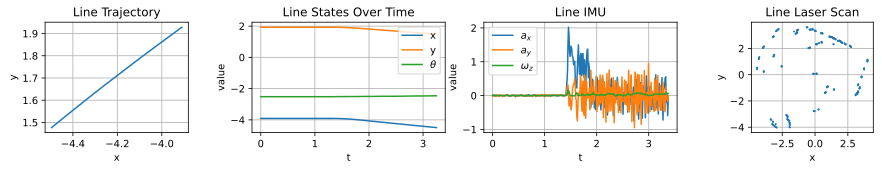

In [181]:
make_graph("Line")

<i><p style="text-align: center">Figure 1: The robot was given the input $u=[v_{robot\ x}\ \omega_z] = [1\ 0]^\intercal$. The trajectory clearly illustrates the robot travelling in a straight line. $\theta_z$ successfully remained constant. The acceleration graph compliments the trajectory well because the robot only ever accelerated in its "forward" direction. The measurement is very noisy when the motors are actuated. Since the robot was close to the corner, the scan ranges described the straight walls clearly.</p></i>

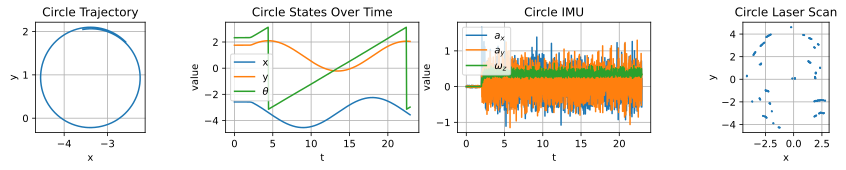

In [193]:
make_graph("Circle")

<i><p style="text-align: center">Figure 2: The trajectory plot depicts the robot travelling in a near perfect circle. The robot was given the input $u=[1\ 1]^\intercal$. Angular velocity measurement clearly indicates that the robot was turning at a constant speed. It appears that the speed controller produces steady state error comparing $u$ and $\omega_z$ in the IMU measurement.</p></i>

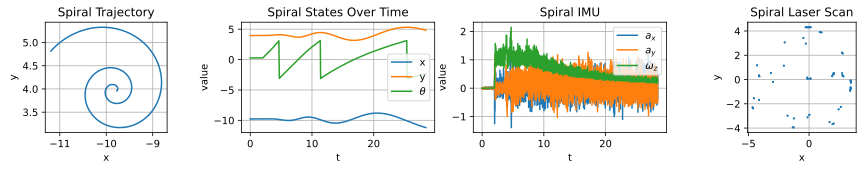

In [194]:
make_graph("Spiral")

<i><p style="text-align: center">Figure 3: The robot was given the input $u=[0.05t\ \ 1]^\intercal$. The trajectory shows how the robot started close to (-10, 4) and spiraled outwards. Following $u$, the linear velocity slowly increased over time while the angular velocity stayed constant. $\omega_z$ measurement only matched $u$ at the start but quickly decreased near 0. One explanation for this behaviour could be due to discrepancies between the hardware limits of the motor speed and the speeds calculated by the controller. That is to say, the controller calculates the required wheel speed, and then scales these to the maximum possible speeds. For example, we want $[2,7]$ but the maximum possible speed is $[3,3]$. The speed that gets commanded would then be $[6/7, 3]$</p></i>

In [192]:
img_pil = PIL.Image.open("map.pgm")

corridor = PIL.Image.open("corridor.pgm")

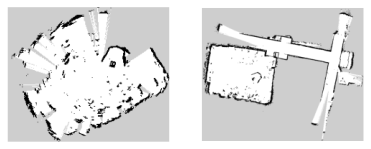

In [197]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(img_pil, cmap="gray")
axes[0].axis("off")
axes[1].imshow(corridor, cmap="gray")
axes[1].axis("off")
print()

<i><p style="text-align: center;">Figure 4: The left greyscale SLAM map shows the obstacle course in the room. The right greyscale SLAM map shows the lab corridor. The corridor boundaries are estimated well because they remain perpendicular to each other, and are relatively well defined. The room, on the other hand, is fuzzier because the robot only roamed inside the obstacle course; additional obstacles like people and occupied chairs were not static, hence lots of broken artificial boundaries were created.</p></i>

## Conclusion

We observed lots of noise while the robot is in motion in all three maneuvers. It could be caused by the vibration in the chassis, imposed by the limitations of the physical realm and mechanical imperfection. It would be beneficial to use a low-pass filter while reading the IMU sensor data stream for feedback control. The individual laser scan measurements don't have enough information to define where the obstacles are; when combined with motion, however, boundaries can become well defined, as shown in the SLAM maps.